In [61]:
import numpy as np
import cupy as cp
from cupyx.scipy.fft import fftn, ifftn, fftfreq, fftshift, ifftshift
import cupy as cp
import matplotlib.pyplot as plt

In [62]:
omega_1 = 0.1
omega_2 = 20.0
def gaussian(x,y, sigma):
    return 1/(2*cp.pi*cp.square(sigma))*cp.exp(-(cp.square(x)+cp.square(y))/(4*cp.square(sigma)))
def unnormalized_gaussian(x,y,omega):
    return cp.sqrt(2*cp.pi)*omega*gaussian(x,y,omega)
def position_amp_mag(x,y):
    return unnormalized_gaussian(x + 2.5,y,omega_1)/cp.sqrt(2) + unnormalized_gaussian(x - 2.5,y - 3.5,omega_1)/cp.sqrt(2)

def momentum_amp_mag(fx,fy):
    return unnormalized_gaussian(2*cp.pi*fx, 2*cp.pi*fy, omega_2)

def unitary_ft(a, diststep):
    return fftshift(fftn(a)*diststep**2/(2*cp.pi))

def unitary_ift(a, diststep):
    return fftshift(ifftn(2*cp.pi*a/diststep**2))

def padded_fft(a, n, pad_factor):
    return fftn(cp.pad(a, ((pad_factor*n, pad_factor*n),(pad_factor*n, pad_factor*n)), 'constant'))
def padded_ifft(a, n, pad_factor):
    return ifftn(a)[pad_factor*n:(pad_factor+1)*n, pad_factor*n:(pad_factor+1)*n]

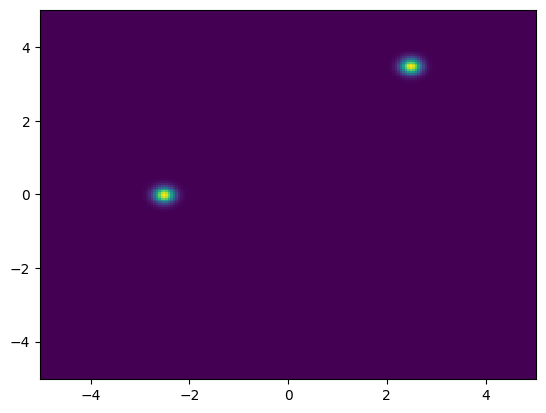

KeyboardInterrupt: 

In [63]:
n = 201
pad_factor = 3
rangeMin = -5.
rangeMax = 5.
diststep = (rangeMax-rangeMin)/n
delta_k = 2*cp.pi/(n*diststep)
x = cp.linspace(rangeMin, rangeMax, n)
y = cp.linspace(rangeMin, rangeMax, n)
px = fftfreq((2*pad_factor + 1)*n, diststep)
py = fftfreq((2*pad_factor + 1)*n, diststep)

X, Y = cp.meshgrid(x,y)
Px, Py = cp.meshgrid(px, py)
Px_sorted, Py_sorted = fftshift(Px), fftshift(Py)

pos_amp_mag = position_amp_mag(X,Y)
# mom_amp_mag = np.abs(fftn(pos_amp_mag*np.exp(1j*cp.pi/2*(0.5*X)/diststep))*diststep**2/(2*cp.pi))
unnormalized_mom_amp_mag = momentum_amp_mag(Px, Py)

mom_amp_mag = cp.sqrt(cp.sum(cp.square(pos_amp_mag))*diststep**2/(cp.sum(cp.square(cp.abs(unnormalized_mom_amp_mag)))*delta_k**2))*unnormalized_mom_amp_mag

plt.pcolor(X.get(), Y.get(), pos_amp_mag.get())
plt.show()
plt.pcolor(fftshift(mom_amp_mag).get())
plt.show()

In [ ]:
print(cp.sum(cp.square(pos_amp_mag))*diststep**2)
print(cp.sum(cp.square(cp.abs(fftn(pos_amp_mag)*diststep**2/(2*cp.pi))))*delta_k**2)
print(cp.sum(cp.square(cp.abs(mom_amp_mag)))*delta_k**2)
print(cp.sum(cp.square(cp.abs(ifftn(mom_amp_mag, s=(n, n))*(2*cp.pi/diststep**2))))*diststep**2)

0.9900745031063588
0.9900745031063588
0.9900745031063586
0.9900745031063584


In [ ]:
print(delta_k)
print(2*np.pi*(Px_sorted[0][1] - Px_sorted[0][0]))

0.6283185307179586
0.6283185307179564


In [ ]:
print(cp.sum(Px*cp.square(mom_amp_mag)), cp.sum(Py*cp.square(mom_amp_mag)))
print(cp.sum(Px*cp.square(cp.abs(unitary_ft(pos_amp_mag, diststep)))), cp.sum(Py*cp.square(cp.abs(unitary_ft(pos_amp_mag, diststep)))))

-8.673617379884035e-19 -1.0550642390999565e-17
1.1318742002741482 1.1318742002741486


In [64]:
def one_step_of_GS(cur_pos, measured_pos_mag, measured_mom_mag, diststep):
    n = measured_pos_mag.shape[0]
    cur_mom = padded_fft(cur_pos, n, pad_factor)*diststep**2/(2*cp.pi)
    next_mom = measured_mom_mag*cp.exp(1j * cp.angle(cur_mom))
    next_pos = padded_ifft(next_mom, n, pad_factor)*(2*cp.pi/diststep**2)
    return measured_pos_mag*cp.exp(1j * cp.angle(next_pos)), next_mom

In [65]:
for i in range(0,100):
    cur_pos_amp, cur_mom_amp = one_step_of_GS(pos_amp_mag, pos_amp_mag, mom_amp_mag, diststep)
    # print(cp.sum(cp.square(cp.abs(new_pos_amp)))*diststep**2)
    # plt.pcolor(X, Y, cp.abs(cur_pos_amp))
    # plt.show()
    # plt.pcolor(Px_sorted, Py_sorted, cp.abs(cur_mom_amp))
plt.pcolor(X.get(), Y.get(), cp.abs(ifftn(cur_mom_amp)*(2*cp.pi/diststep**2)).get())

ValueError: operands could not be broadcast together with shapes (201, 201) (0, 0)

In [ ]:
print(cp.sum(cp.square(cp.abs(cur_mom_amp)))*delta_k**2)
print(cp.sum(cp.square(cp.abs(ifftn(cur_mom_amp)*(2*cp.pi/diststep**2))))*diststep**2)

0.9900745031063586
0.9900745031063584


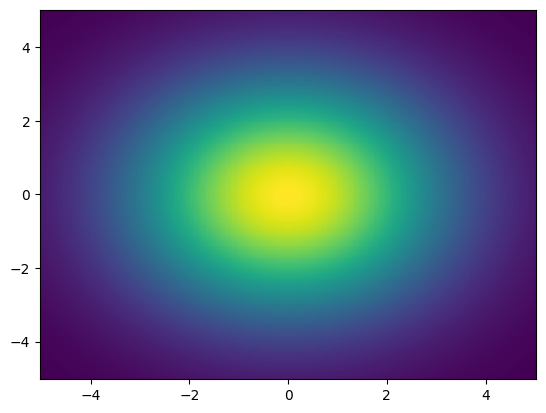

In [ ]:
plt.pcolor(X.get(), Y.get(), fftshift(cp.abs(cur_mom_amp)).get())